In [54]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#from datetime import date
import re

# 1. Exploration des données

In [ ]:
# !curl https://data.ukedc.rl.ac.uk/browse/edc/efficiency/residential/EnergyConsumption/Domestic/UK-DALE-2015/UK-DALE-disaggregated/ukdale.h5.tgz -o ukdale.h5.tgz
# !tar xvfz ukdale.h5.tgz
# !rm ukdale.h5.tgz

In [55]:
store = pd.HDFStore('ukdale.h5')

In [58]:
def resample_meter(store=None, building=1, meter=1, period='1min', cutoff=None):
    key = '/building{}/elec/meter{}'.format(building,meter)
    m = store[key]
    v = m.values.flatten()
    t = m.index
    s = pd.Series(v, index=t).clip(0.,cutoff)
    s[s<10.] = 0.
    return s.resample('1s').ffill(limit=300).fillna(0.).resample(period).mean().tz_convert(None)

def get_series(datastore, house, label, cutoff):
    filename = './house_%1d_labels.dat' %house
    print(filename)
    labels = pd.read_csv(filename, delimiter=' ', header=None, index_col=0).to_dict()[1]
    
    for i in labels:
        if labels[i] == label:
            print(i, labels[i])
            s = resample_meter(store, house, i, '1min', cutoff)
            #s = resample_meter(store, house, i, '6s', cutoff)
    
    s.index.name = 'datetime'
    
    return s

def get_all_series(datastore, house):
    filename = 'data/ukdale/house_%1d_labels.dat' %house
    labels = pd.read_csv(filename, delimiter=' ', header=None, index_col=0).to_dict()[1]
    cut_offs_dict = {'aggregate': 10000., 'kettle': 3100., 'fridge': 300., 'washing_machine': 2500., 'microwave': 3000., 'dishwasher': 2500.}
    
    s = {}
    for i, l in labels.items():
        s[i] = resample_meter(store, house, i, '1min', cut_offs_dict.get(i, None))
        s[i].index.name = 'datetime'
        s[i].name = l

    df = pd.concat([c for c in s.values()], axis=1)
    df.fillna(method='pad', inplace=True)
    
    return df

In [59]:
house = 2
house2 = get_all_series(store, house)
house2 = house2.rename(columns={'aggregate':'mains'})
house2 = house2.dropna(axis=0).resample('1min').interpolate('linear')
house2.head()

,mains,laptop,monitor,speakers,server,router,server_hdd,kettle,rice_cooker,running_machine,laptop2,washing_machine,dish_washer,fridge,microwave,toaster,playstation,modem,cooker
datetime,,,,,,,,,,,,,,,,,,,
2013-05-20 21:28:00,92.599998,6.066667,20.233334,3.850000,4.766667,0.0,3.850000,0.0,0.0,0.0,0.0,0.0,0.0,11.000000,0.0,0.0,0.0,0.0,0.0
2013-05-20 21:29:00,250.183334,15.533334,60.900002,10.583333,12.900000,0.0,10.900000,0.0,0.0,0.0,0.0,0.0,0.0,11.000000,0.0,0.0,0.0,0.0,0.0
2013-05-20 21:30:00,248.183334,18.400000,60.816666,10.700000,13.000000,0.0,11.000000,0.0,0.0,0.0,0.0,0.0,0.0,11.000000,0.0,0.0,0.0,0.0,0.0
2013-05-20 21:31:00,252.883331,17.383333,60.766666,10.900000,12.900000,0.0,10.900000,0.0,0.0,0.0,0.0,0.0,0.0,10.933333,0.0,0.0,0.0,0.0,0.0
2013-05-20 21:32:00,250.600006,15.433333,60.900002,10.766666,12.900000,0.0,10.783334,0.0,0.0,0.0,0.0,0.0,0.0,10.966666,0.0,0.0,0.0,0.0,0.0


In [60]:
# house2.to_csv('data/ukdale/house_2_powers.csv')
house2 = pd.read_csv('data/ukdale/house_2_powers.zip', index_col='datetime')
house2.index = pd.to_datetime(house2.index)
house2 = house2.asfreq('min')
house2.head()

,mains,laptop,monitor,speakers,server,router,server_hdd,kettle,rice_cooker,running_machine,laptop2,washing_machine,dish_washer,fridge,microwave,toaster,playstation,modem,cooker
datetime,,,,,,,,,,,,,,,,,,,
2013-05-20 21:28:00,92.599998,6.066667,20.233334,3.850000,4.766667,0.0,3.850000,0.0,0.0,0.0,0.0,0.0,0.0,11.000000,0.0,0.0,0.0,0.0,0.0
2013-05-20 21:29:00,250.183334,15.533334,60.900002,10.583333,12.900000,0.0,10.900000,0.0,0.0,0.0,0.0,0.0,0.0,11.000000,0.0,0.0,0.0,0.0,0.0
2013-05-20 21:30:00,248.183334,18.400000,60.816666,10.700000,13.000000,0.0,11.000000,0.0,0.0,0.0,0.0,0.0,0.0,11.000000,0.0,0.0,0.0,0.0,0.0
2013-05-20 21:31:00,252.883331,17.383333,60.766666,10.900000,12.900000,0.0,10.900000,0.0,0.0,0.0,0.0,0.0,0.0,10.933333,0.0,0.0,0.0,0.0,0.0
2013-05-20 21:32:00,250.600006,15.433333,60.900002,10.766666,12.900000,0.0,10.783334,0.0,0.0,0.0,0.0,0.0,0.0,10.966666,0.0,0.0,0.0,0.0,0.0


In [61]:
# all_groups = list(house2.columns)
all_groups = ['laptop', 'monitor', 'speakers', 'kettle', 'rice_cooker', 'running_machine', 'laptop2', 'washing_machine', 'dish_washer', 'microwave', 'toaster','playstation', 'cooker']
active_labels = ['kettle', 'rice_cooker', 'running_machine', 'laptop2', 'washing_machine', 'dish_washer', 'microwave', 'toaster', 'cooker']

In [7]:
house2.describe()

,mains,laptop,monitor,speakers,server,router,server_hdd,kettle,rice_cooker,running_machine,laptop2,washing_machine,dish_washer,fridge,microwave,toaster,playstation,modem,cooker
count,204948.000000,204948.000000,204948.000000,204948.000000,204948.000000,204948.000000,204948.000000,204948.000000,204948.000000,204948.000000,204948.000000,204948.000000,204948.000000,204948.000000,204948.000000,204948.00000,204948.000000,204948.000000,204948.000000
mean,257.422363,7.416047,17.024786,3.580989,11.633378,0.007785,0.145764,21.225454,1.933322,1.549109,3.318059,6.912834,34.753113,38.647209,5.542347,0.27298,0.024126,0.097238,0.080302
std,415.957001,12.353094,27.083941,4.959078,5.073303,0.253770,1.377470,232.842300,26.838779,21.467243,8.637319,104.389374,255.872940,39.561359,75.565361,14.15031,0.971448,0.436345,1.880122
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
25%,126.949997,0.000000,0.000000,0.000000,12.800000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10.300000,0.000000,0.00000,0.000000,0.000000,0.000000
50%,182.899994,0.000000,0.000000,0.000000,14.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10.900000,0.000000,0.00000,0.000000,0.000000,0.000000
75%,257.933319,15.233334,59.099998,10.200000,14.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,85.650002,0.000000,0.00000,0.000000,0.000000,0.000000
max,5234.133301,210.000000,130.000000,12.400000,18.316668,82.633331,191.699997,3119.600098,452.383331,747.333313,262.100006,2281.716553,2194.899902,251.399994,1418.900024,997.00000,109.433334,68.500000,412.066681


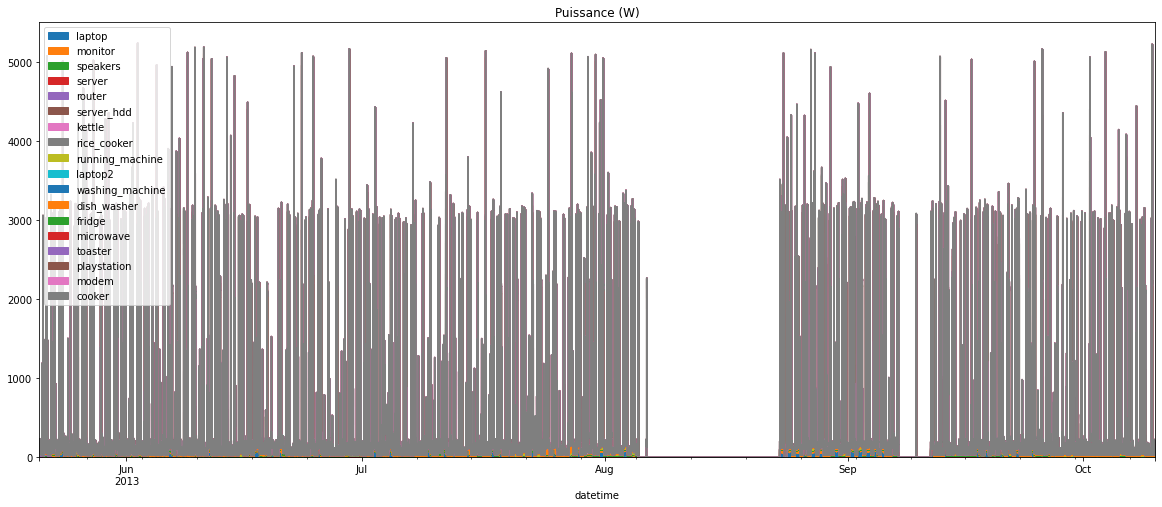

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(20,8))
house2.loc[:, all_groups[1:]].plot.area(title='Puissance (W)', ax=ax);

ax.legend(loc='upper left');

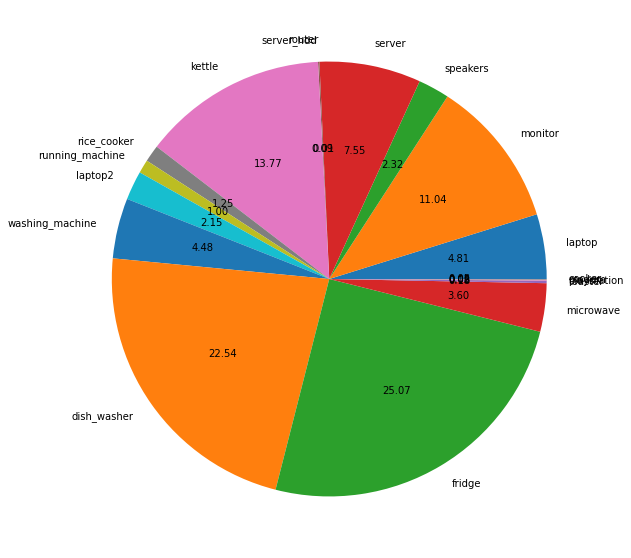

In [18]:
house2[all_groups[1:]].mean().plot(kind='pie', autopct='%.2f', figsize=(10,10), label="");

# 2. Ajout des labels activité

Une autre approche pourrait être de considérer qu'il y a activité si certaines puissances sont supérieures à 0 (i.e. il y a bien une activité électrique sur ces équipements).

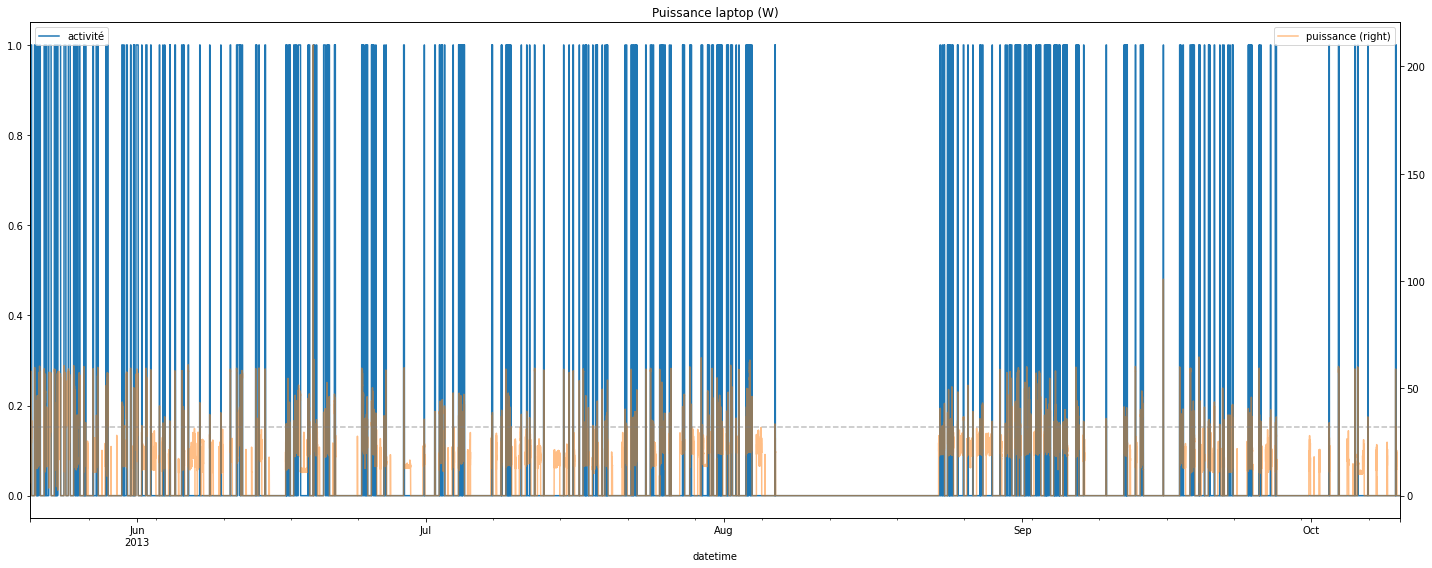

In [38]:
# laptop
#window = ['2013-05-20 21:28:00+00:00', '2013-05-27 21:28:00+00:00']
window = ['2013-05-20 21:28:00+00:00', '2013-10-10 05:15:00+00:00']
fig, ax = plt.subplots(1,1 , figsize=(20,8))

house2 = house2[all_groups].interpolate(method='linear')
tol = house2[all_groups].mean() + house2[all_groups].std() * 2

col = "laptop"

((((house2[col] > tol[col])*1).rolling('30min', center=True).mean() > 0)*1).loc[window[0]:window[1]].plot(label='activité', ax=ax);
axr = house2[col].loc[window[0]:window[1]].plot(title=f'Puissance {col} (W)',secondary_y=True, label='puissance', ax=ax, alpha=0.5);
axr.axhline(y=tol[col], linestyle='dashed', color='gray', alpha=0.5);

ax.legend(loc='upper left');
axr.legend(loc='upper right');

fig.tight_layout();

Faibles puissances.

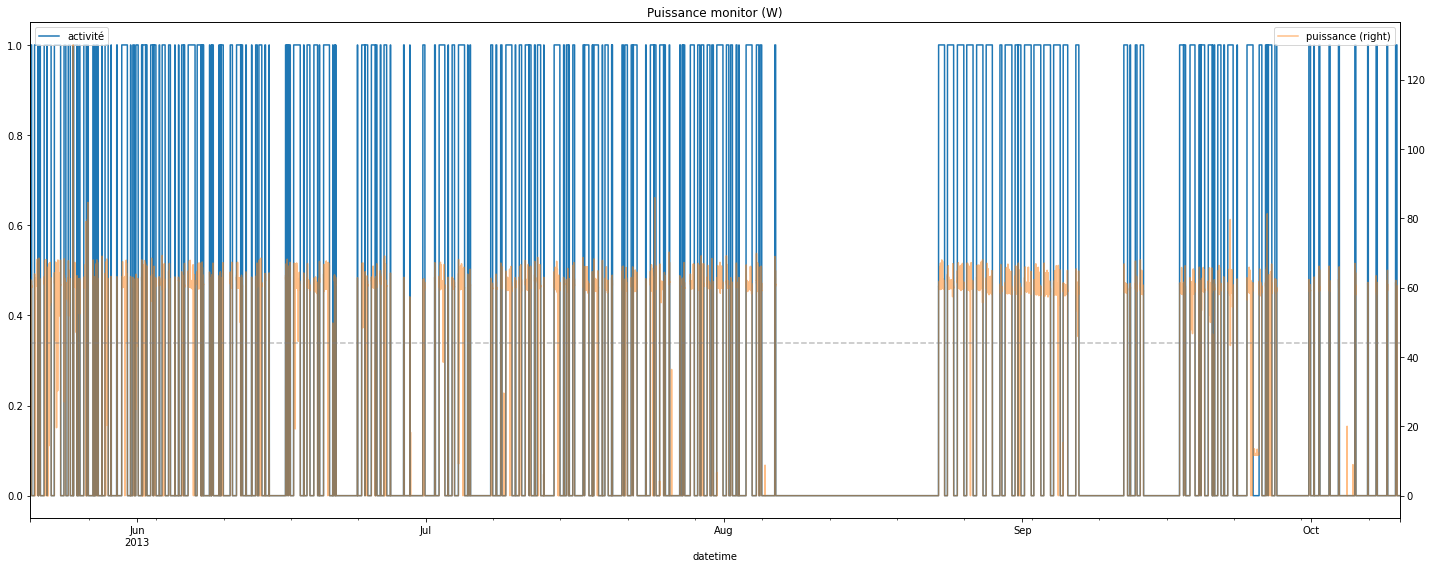

In [39]:
# monitor
#window = ['2013-05-20 21:28:00+00:00', '2013-05-27 21:28:00+00:00']
window = ['2013-05-20 21:28:00+00:00', '2013-10-10 05:15:00+00:00']
fig, ax = plt.subplots(1,1 , figsize=(20,8))

house2 = house2[all_groups].interpolate(method='linear')
tol = house2[all_groups].mean() + house2[all_groups].std() * 1

col = 'monitor'

((((house2[col] > tol[col])*1).rolling('30min', center=True).mean() > 0)*1).loc[window[0]:window[1]].plot(label='activité', ax=ax);
axr = house2[col].loc[window[0]:window[1]].plot(title=f'Puissance {col} (W)',secondary_y=True, label='puissance', ax=ax, alpha=0.5);
axr.axhline(y=tol[col], linestyle='dashed', color='gray', alpha=0.5);

ax.legend(loc='upper left');
axr.legend(loc='upper right');

fig.tight_layout();

Faibles puissances : à exclure.

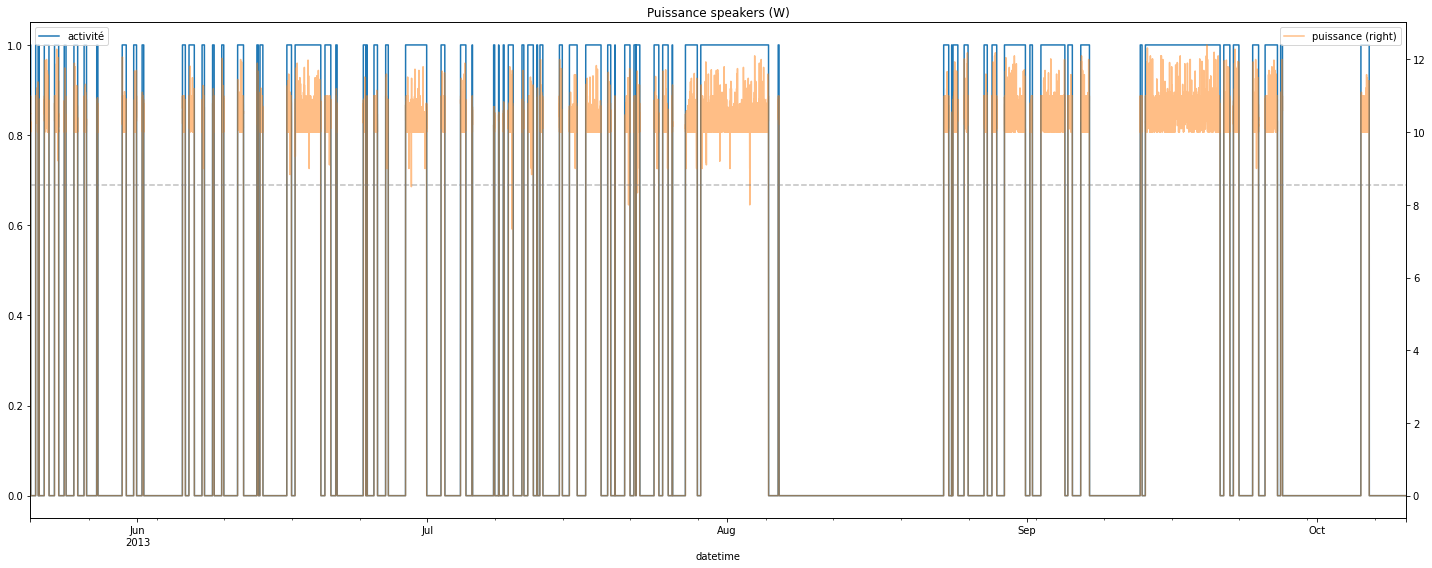

In [40]:
# speakers
#window = ['2013-05-20 21:28:00+00:00', '2013-05-27 21:28:00+00:00']
window = ['2013-05-20 21:28:00+00:00', '2013-10-10 05:15:00+00:00']
fig, ax = plt.subplots(1,1 , figsize=(20,8))

house2 = house2[all_groups].interpolate(method='linear')
tol = house2[all_groups].mean() + house2[all_groups].std() * 1

col = 'speakers'

((((house2[col] > tol[col])*1).rolling('30min', center=True).mean() > 0)*1).loc[window[0]:window[1]].plot(label='activité', ax=ax);
axr = house2[col].loc[window[0]:window[1]].plot(title=f'Puissance {col} (W)',secondary_y=True, label='puissance', ax=ax, alpha=0.5);
axr.axhline(y=tol[col], linestyle='dashed', color='gray', alpha=0.5);

ax.legend(loc='upper left');
axr.legend(loc='upper right');

fig.tight_layout();

Faibles puissances : à exclure.

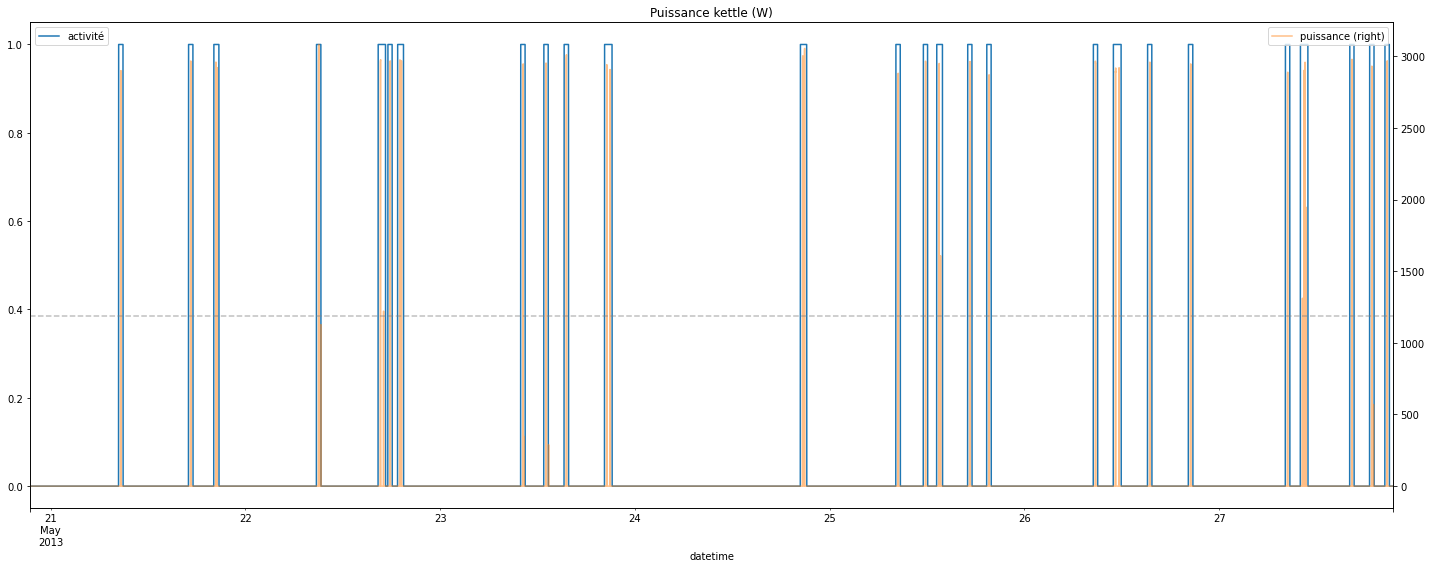

In [44]:
# kettle
window = ['2013-05-20 21:28:00+00:00', '2013-05-27 21:28:00+00:00']
#window = ['2013-05-20 21:28:00+00:00', '2013-10-10 05:15:00+00:00']
fig, ax = plt.subplots(1,1 , figsize=(20,8))

house2 = house2[all_groups].interpolate(method='linear')
tol = house2[all_groups].mean() + house2[all_groups].std() * 5

col = 'kettle'

((((house2[col] > tol[col])*1).rolling('30min', center=True).mean() > 0)*1).loc[window[0]:window[1]].plot(label='activité', ax=ax);
axr = house2[col].loc[window[0]:window[1]].plot(title=f'Puissance {col} (W)',secondary_y=True, label='puissance', ax=ax, alpha=0.5);
axr.axhline(y=tol[col], linestyle='dashed', color='gray', alpha=0.5);

ax.legend(loc='upper left');
axr.legend(loc='upper right');

fig.tight_layout();

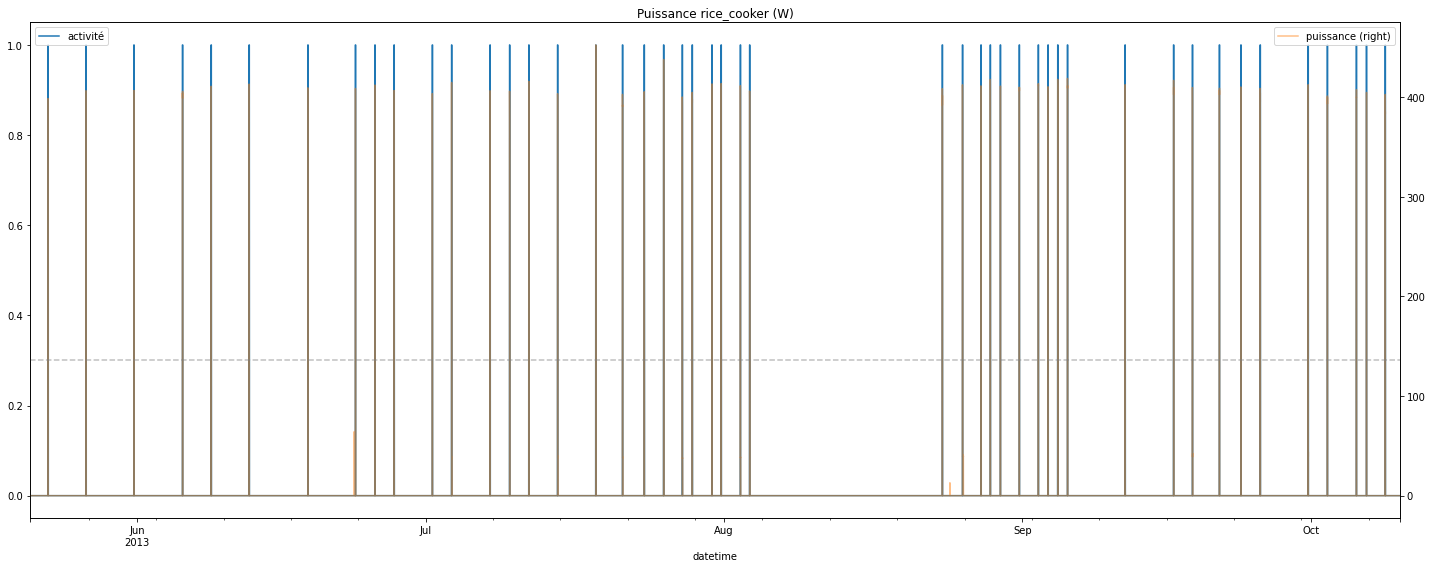

In [47]:
# rice_cooker
#window = ['2013-05-20 21:28:00+00:00', '2013-05-27 21:28:00+00:00']
window = ['2013-05-20 21:28:00+00:00', '2013-10-10 05:15:00+00:00']
fig, ax = plt.subplots(1,1 , figsize=(20,8))

house2 = house2[all_groups].interpolate(method='linear')
tol = house2[all_groups].mean() + house2[all_groups].std() * 5

col = 'rice_cooker'

((((house2[col] > tol[col])*1).rolling('30min', center=True).mean() > 0)*1).loc[window[0]:window[1]].plot(label='activité', ax=ax);
axr = house2[col].loc[window[0]:window[1]].plot(title=f'Puissance {col} (W)',secondary_y=True, label='puissance', ax=ax, alpha=0.5);
axr.axhline(y=tol[col], linestyle='dashed', color='gray', alpha=0.5);

ax.legend(loc='upper left');
axr.legend(loc='upper right');

fig.tight_layout();

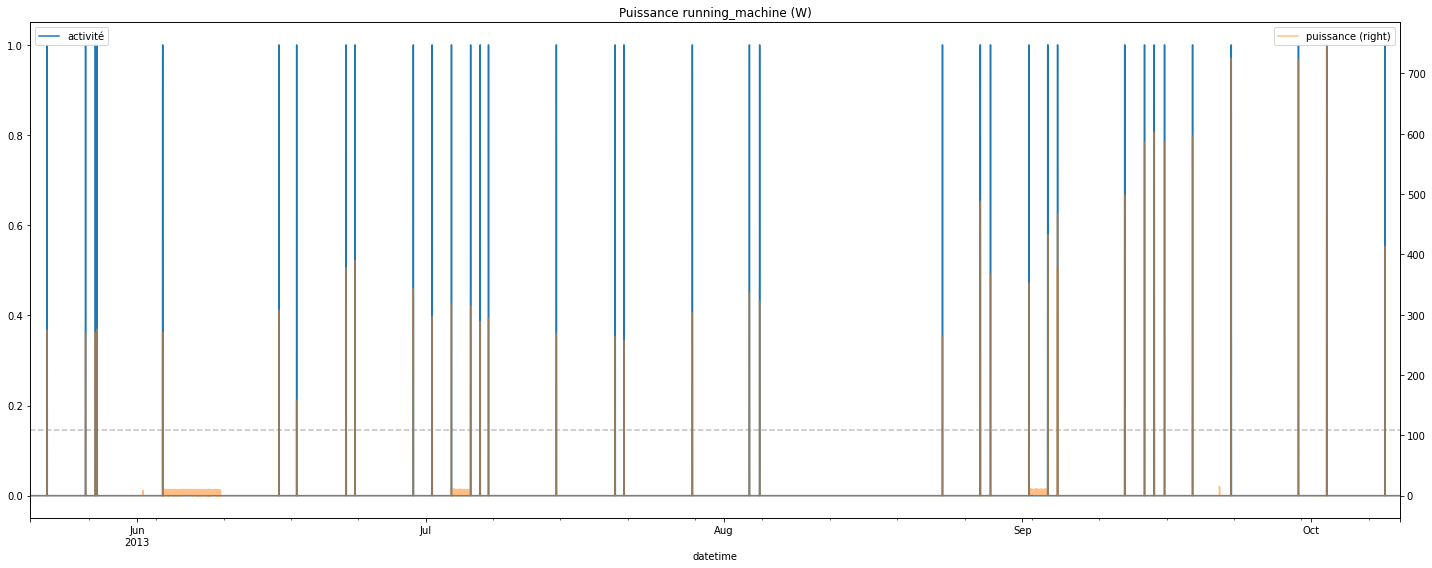

In [48]:
# running_machine
#window = ['2013-05-20 21:28:00+00:00', '2013-05-27 21:28:00+00:00']
window = ['2013-05-20 21:28:00+00:00', '2013-10-10 05:15:00+00:00']
fig, ax = plt.subplots(1,1 , figsize=(20,8))

house2 = house2[all_groups].interpolate(method='linear')
tol = house2[all_groups].mean() + house2[all_groups].std() * 5

col = 'running_machine'

((((house2[col] > tol[col])*1).rolling('30min', center=True).mean() > 0)*1).loc[window[0]:window[1]].plot(label='activité', ax=ax);
axr = house2[col].loc[window[0]:window[1]].plot(title=f'Puissance {col} (W)',secondary_y=True, label='puissance', ax=ax, alpha=0.5);
axr.axhline(y=tol[col], linestyle='dashed', color='gray', alpha=0.5);

ax.legend(loc='upper left');
axr.legend(loc='upper right');

fig.tight_layout();

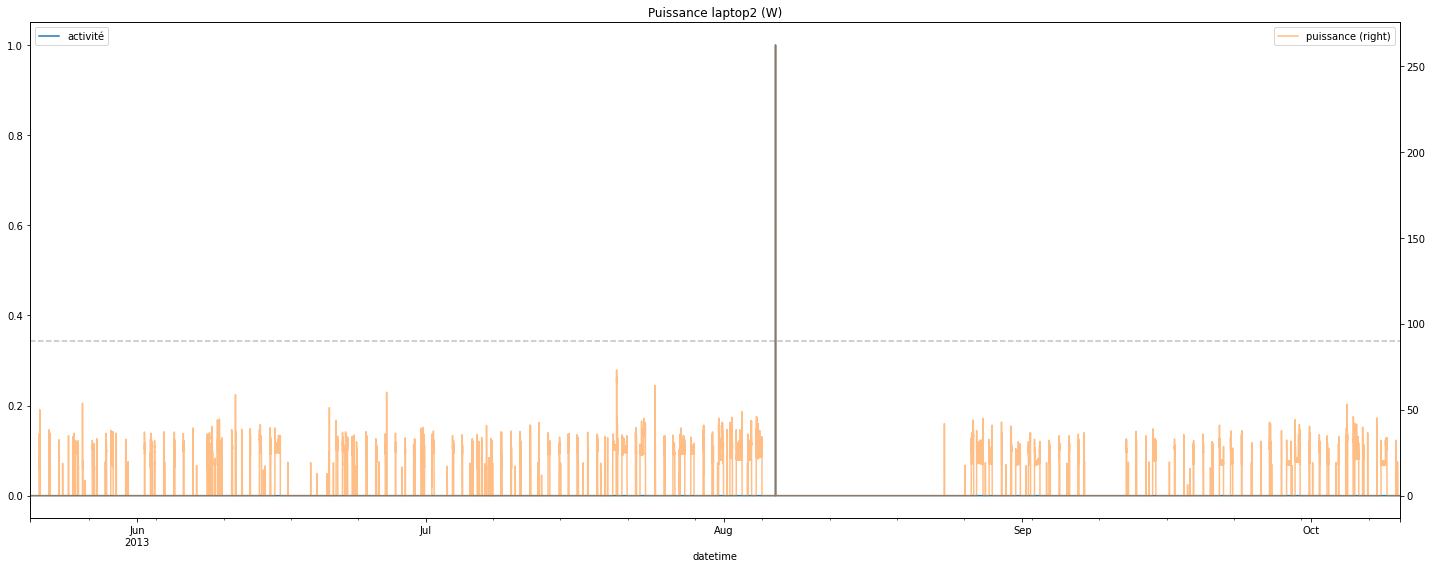

In [24]:
# laptop2
#window = ['2013-05-20 21:28:00+00:00', '2013-05-27 21:28:00+00:00']
window = ['2013-05-20 21:28:00+00:00', '2013-10-10 05:15:00+00:00']
fig, ax = plt.subplots(1,1 , figsize=(20,8))

house2 = house2[all_groups].interpolate(method='linear')
tol = house2[all_groups].mean() + house2[all_groups].std() * 10

col = 'laptop2'

((((house2[col] > tol[col])*1).rolling('30min', center=True).mean() > 0)*1).loc[window[0]:window[1]].plot(label='activité', ax=ax);
axr = house2[col].loc[window[0]:window[1]].plot(title=f'Puissance {col} (W)',secondary_y=True, label='puissance', ax=ax, alpha=0.5);
axr.axhline(y=tol[col], linestyle='dashed', color='gray', alpha=0.5);

ax.legend(loc='upper left');
axr.legend(loc='upper right');

fig.tight_layout();

Faibles puissances : on n'extrait que les grosses variations.

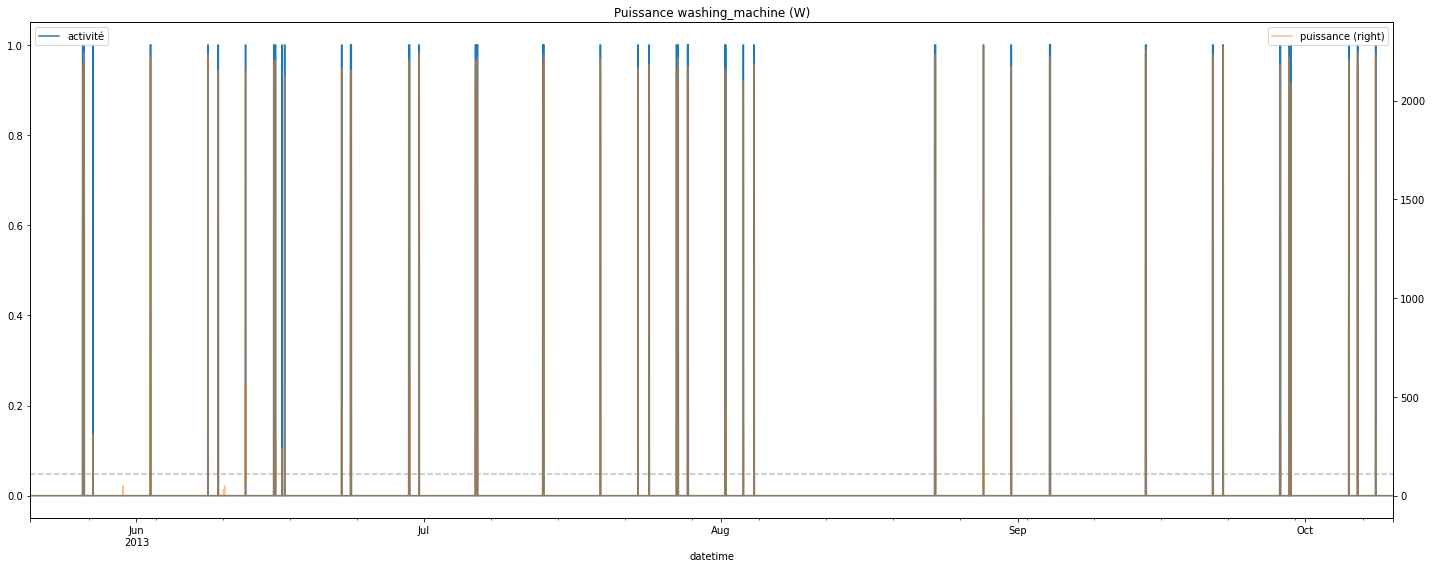

In [29]:
# washing_machine
#window = ['2013-05-20 21:28:00+00:00', '2013-05-27 21:28:00+00:00']
window = ['2013-05-20 21:28:00+00:00', '2013-10-10 05:15:00+00:00']
fig, ax = plt.subplots(1,1 , figsize=(20,8))

house2 = house2[all_groups].interpolate(method='linear')
tol = house2[all_groups].mean() + house2[all_groups].std() * 1

col = 'washing_machine'

((((house2[col] > tol[col])*1).rolling('30min', center=True).mean() > 0)*1).loc[window[0]:window[1]].plot(label='activité', ax=ax);
axr = house2[col].loc[window[0]:window[1]].plot(title=f'Puissance {col} (W)',secondary_y=True, label='puissance', ax=ax, alpha=0.5);
axr.axhline(y=tol[col], linestyle='dashed', color='gray', alpha=0.5);

ax.legend(loc='upper left');
axr.legend(loc='upper right');

fig.tight_layout();

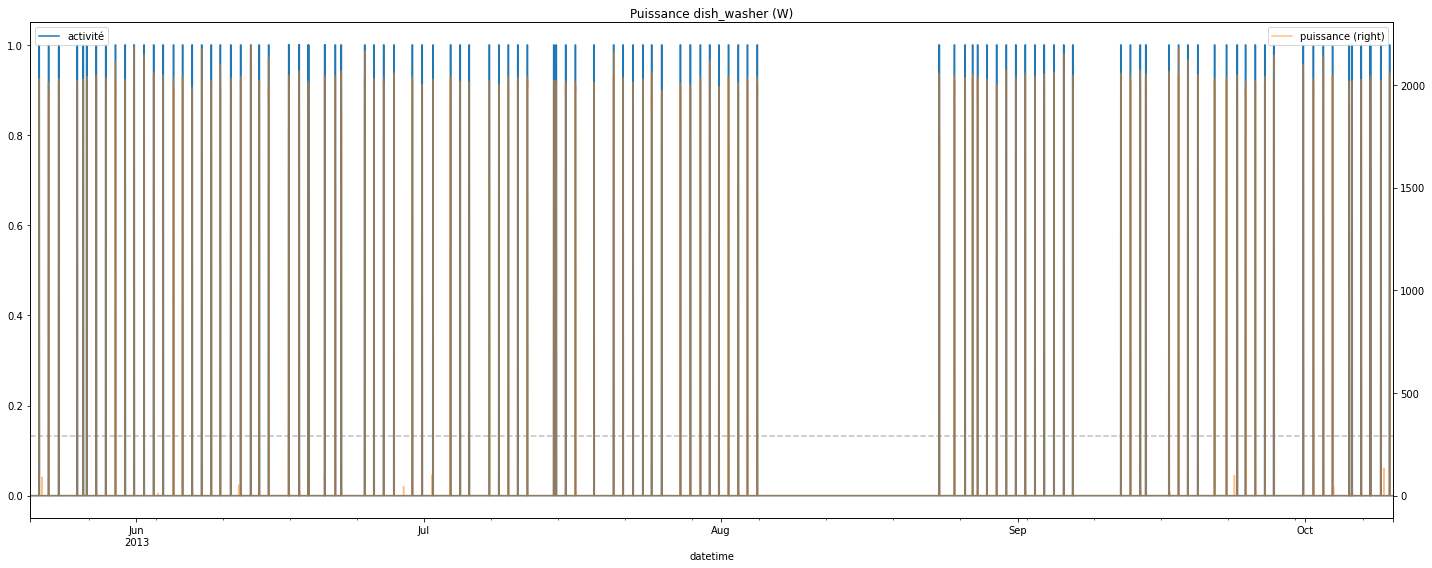

In [30]:
# dish_washer
#window = ['2013-05-20 21:28:00+00:00', '2013-05-27 21:28:00+00:00']
window = ['2013-05-20 21:28:00+00:00', '2013-10-10 05:15:00+00:00']
fig, ax = plt.subplots(1,1 , figsize=(20,8))

house2 = house2[all_groups].interpolate(method='linear')
tol = house2[all_groups].mean() + house2[all_groups].std() * 1

col = 'dish_washer'

((((house2[col] > tol[col])*1).rolling('30min', center=True).mean() > 0)*1).loc[window[0]:window[1]].plot(label='activité', ax=ax);
axr = house2[col].loc[window[0]:window[1]].plot(title=f'Puissance {col} (W)',secondary_y=True, label='puissance', ax=ax, alpha=0.5);
axr.axhline(y=tol[col], linestyle='dashed', color='gray', alpha=0.5);

ax.legend(loc='upper left');
axr.legend(loc='upper right');

fig.tight_layout();

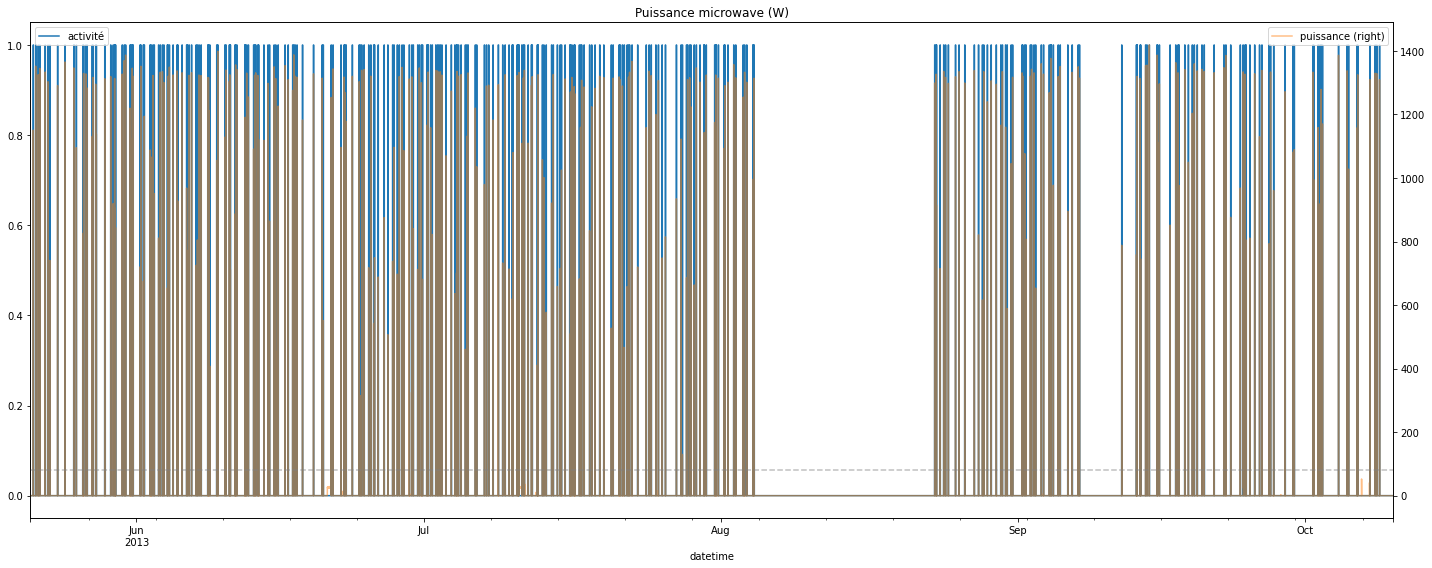

In [31]:
# microwave
#window = ['2013-05-20 21:28:00+00:00', '2013-05-27 21:28:00+00:00']
window = ['2013-05-20 21:28:00+00:00', '2013-10-10 05:15:00+00:00']
fig, ax = plt.subplots(1,1 , figsize=(20,8))

house2 = house2[all_groups].interpolate(method='linear')
tol = house2[all_groups].mean() + house2[all_groups].std() * 1

col = 'microwave'

((((house2[col] > tol[col])*1).rolling('30min', center=True).mean() > 0)*1).loc[window[0]:window[1]].plot(label='activité', ax=ax);
axr = house2[col].loc[window[0]:window[1]].plot(title=f'Puissance {col} (W)',secondary_y=True, label='puissance', ax=ax, alpha=0.5);
axr.axhline(y=tol[col], linestyle='dashed', color='gray', alpha=0.5);

ax.legend(loc='upper left');
axr.legend(loc='upper right');

fig.tight_layout();

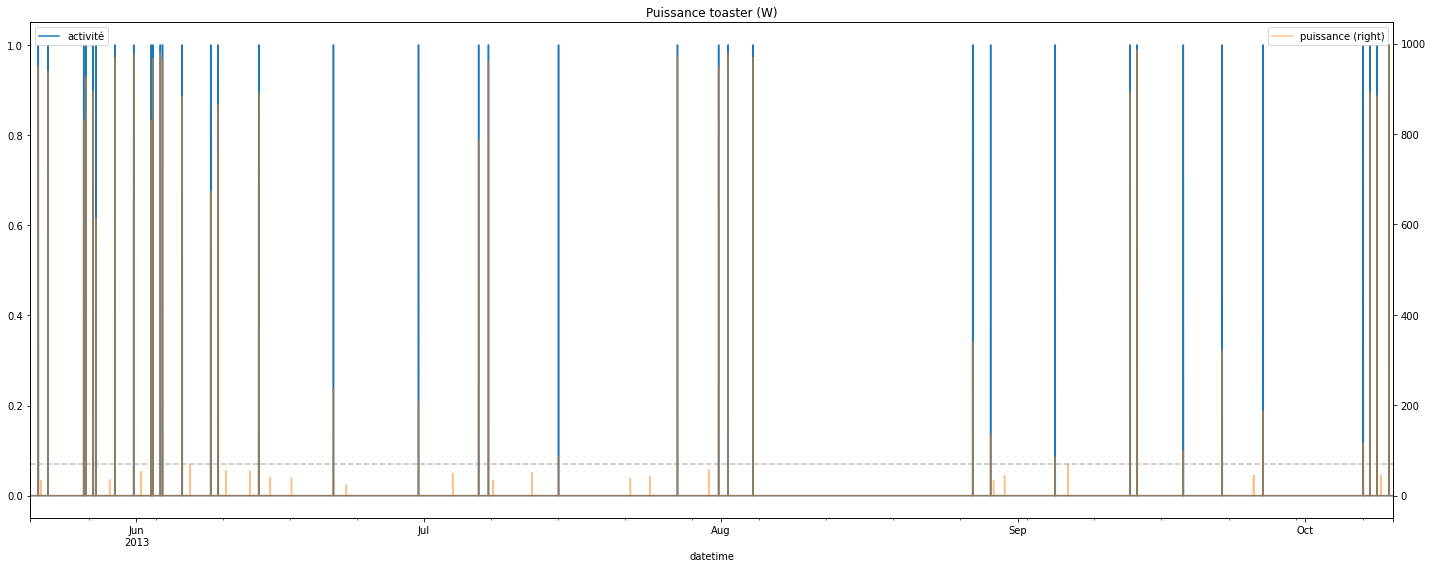

In [37]:
# toaster
# window = ['2013-06-20 21:28:00+00:00', '2013-07-27 21:28:00+00:00']
window = ['2013-05-20 21:28:00+00:00', '2013-10-10 05:15:00+00:00']
fig, ax = plt.subplots(1,1 , figsize=(20,8))

house2 = house2[all_groups].interpolate(method='linear')
tol = house2[all_groups].mean() + house2[all_groups].std() * 5

col = 'toaster'

((((house2[col] > tol[col])*1).rolling('30min', center=True).mean() > 0)*1).loc[window[0]:window[1]].plot(label='activité', ax=ax);
axr = house2[col].loc[window[0]:window[1]].plot(title=f'Puissance {col} (W)',secondary_y=True, label='puissance', ax=ax, alpha=0.5);
axr.axhline(y=tol[col], linestyle='dashed', color='gray', alpha=0.5);

ax.legend(loc='upper left');
axr.legend(loc='upper right');

fig.tight_layout();

On n'extrait que les grosses variations.

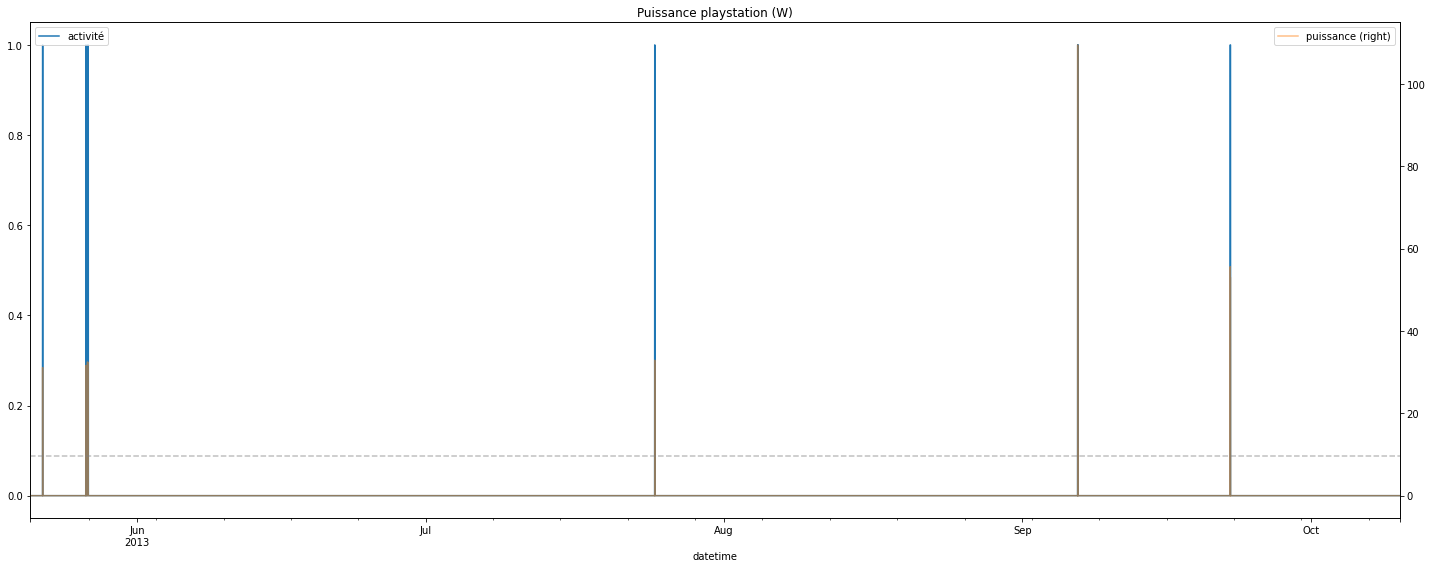

In [39]:
# playstation
# window = ['2013-06-20 21:28:00+00:00', '2013-07-27 21:28:00+00:00']
window = ['2013-05-20 21:28:00+00:00', '2013-10-10 05:15:00+00:00']
fig, ax = plt.subplots(1,1 , figsize=(20,8))

house2 = house2[all_groups].interpolate(method='linear')
tol = house2[all_groups].mean() + house2[all_groups].std() * 10

col = 'playstation'

((((house2[col] > tol[col])*1).rolling('30min', center=True).mean() > 0)*1).loc[window[0]:window[1]].plot(label='activité', ax=ax);
axr = house2[col].loc[window[0]:window[1]].plot(title=f'Puissance {col} (W)',secondary_y=True, label='puissance', ax=ax, alpha=0.5);
axr.axhline(y=tol[col], linestyle='dashed', color='gray', alpha=0.5);

ax.legend(loc='upper left');
axr.legend(loc='upper right');

fig.tight_layout();

Faibles puissances

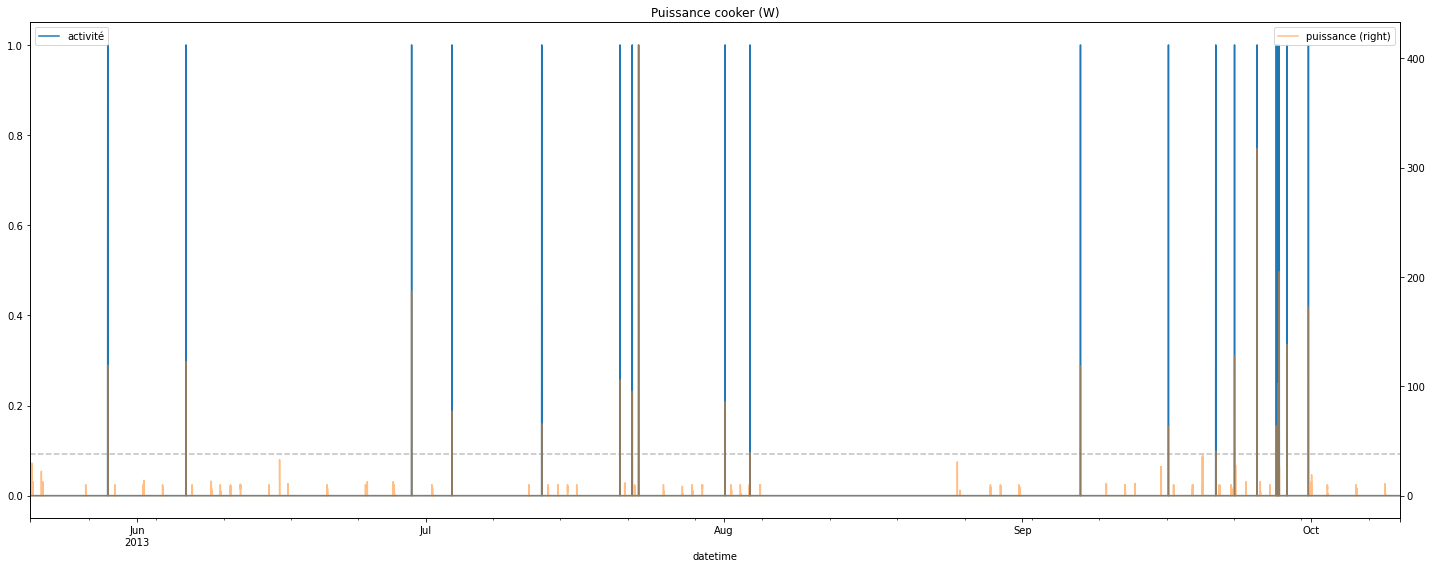

In [42]:
# cooker
# window = ['2013-06-20 21:28:00+00:00', '2013-07-27 21:28:00+00:00']
window = ['2013-05-20 21:28:00+00:00', '2013-10-10 05:15:00+00:00']
fig, ax = plt.subplots(1,1 , figsize=(20,8))

house2 = house2[all_groups].interpolate(method='linear')
tol = house2[all_groups].mean() + house2[all_groups].std() * 20

col = 'cooker'

((((house2[col] > tol[col])*1).rolling('30min', center=True).mean() > 0)*1).loc[window[0]:window[1]].plot(label='activité', ax=ax);
axr = house2[col].loc[window[0]:window[1]].plot(title=f'Puissance {col} (W)',secondary_y=True, label='puissance', ax=ax, alpha=0.5);
axr.axhline(y=tol[col], linestyle='dashed', color='gray', alpha=0.5);

ax.legend(loc='upper left');
axr.legend(loc='upper right');

fig.tight_layout();

Agrégation des résulats : nous allons agréger tous les résultats et tracer le graphe de l'activité vs la courbe de charge sur les appaeils correspondants à de l'activité.

In [62]:
params = pd.DataFrame(data={'tol1mul': [2, # laptop
                                        1, # monitor
                                        1, # speakers
                                        5, # kettle
                                        5, # rice_cooker
                                        5, # running_machine
                                        10, # laptop2
                                        1, # washing_machine
                                        1, # dish_washer
                                        1, # microwave
                                        5, # toaster
                                        10, # playstation
                                        20, # cooker
                                ],
                            'rolling': ['30min',  # laptop
                                        '30min', # monitor
                                        '30min', # speakers
                                        '30min', # kettle
                                        '30min', # rice_cooker
                                        '30min', # running_machine
                                        '30min', # laptop2
                                        '30min', # washing_machine
                                        '30min', # dish_washer
                                        '30min', # microwave
                                        '30min', # toaster
                                        '30min', # playstation
                                        '30min',# cooker
                                ],
                            'tol2': [0, # laptop
                                     0, # monitor
                                     0, # speakers
                                     0, # kettle
                                     0, # rice_cooker
                                     0, # running_machine
                                     0, # laptop2
                                     0, # washing_machine
                                     0, # dish_washer
                                     0, # microwave
                                     0, # toaster
                                     0, # playstation
                                     0, # cooker
                            ]})

In [63]:
house2_activity = pd.DataFrame()

for i, group in enumerate(all_groups):
    if not group in active_labels:
        continue
    
    house2_activity[group] = ((((house2[group] > house2[group].mean() + house2[group].std() * params.loc[i, 'tol1mul'])*1).rolling(params.loc[i, 'rolling'], center=True).mean() > params.loc[i, 'tol2'])*1)


house2['activity'] = (house2_activity[active_labels].any(axis=1))*1

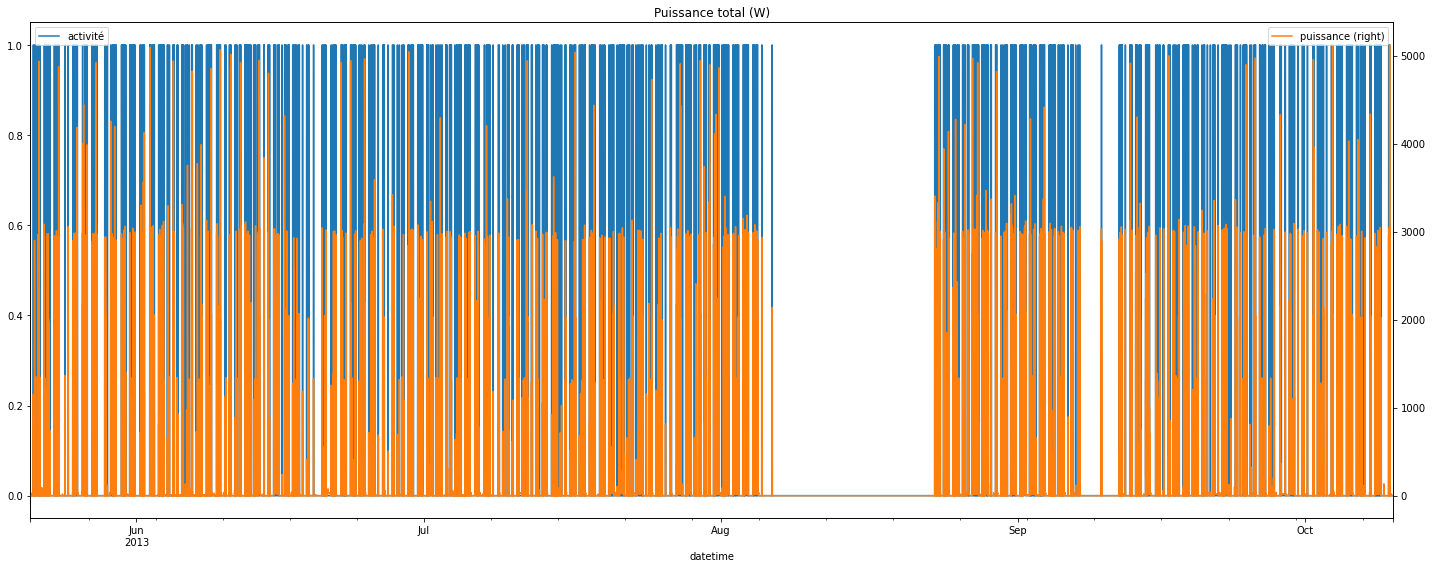

In [50]:
fig, ax = plt.subplots(1,1 , figsize=(20,8))

house2['activity'].resample('1min').nearest().plot(label='activité', ax=ax);
axr = house2[active_labels].sum(axis=1).resample('1min').mean().plot(title=f'Puissance total (W)',secondary_y=True, label='puissance', ax=ax);

ax.legend(loc='upper left');
axr.legend(loc='upper right');

fig.tight_layout();

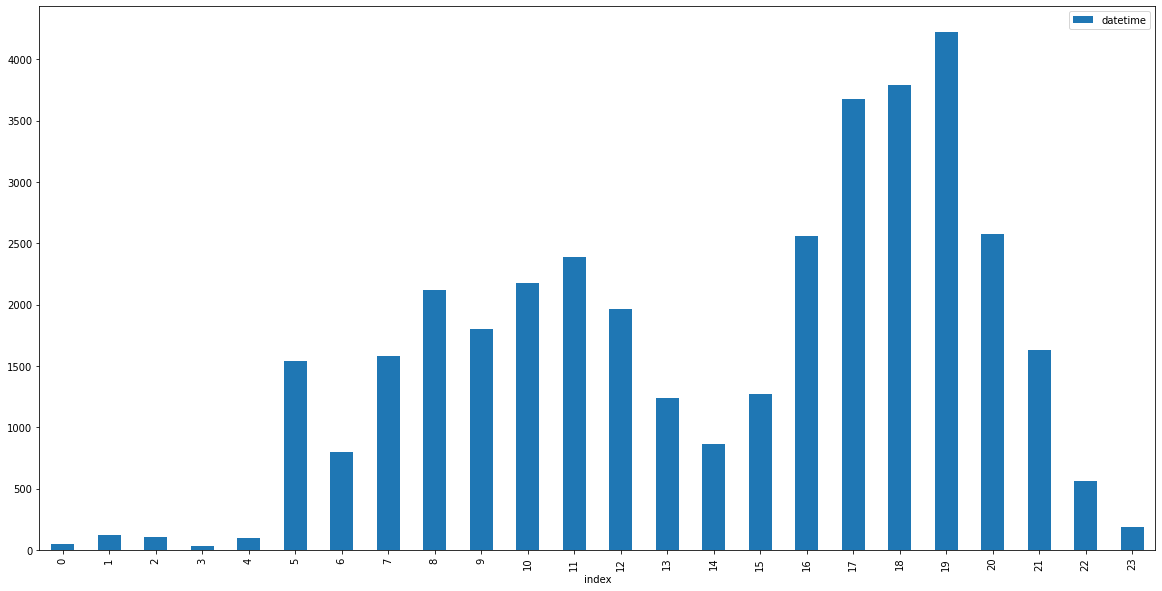

In [64]:
pd.DataFrame(house2[house2['activity'] > 0].index.hour.value_counts()).reset_index(drop=False).sort_values(by='index').plot.bar(x='index', y='datetime', figsize=(20,10), legend='Histogramme activité=f(heure)');


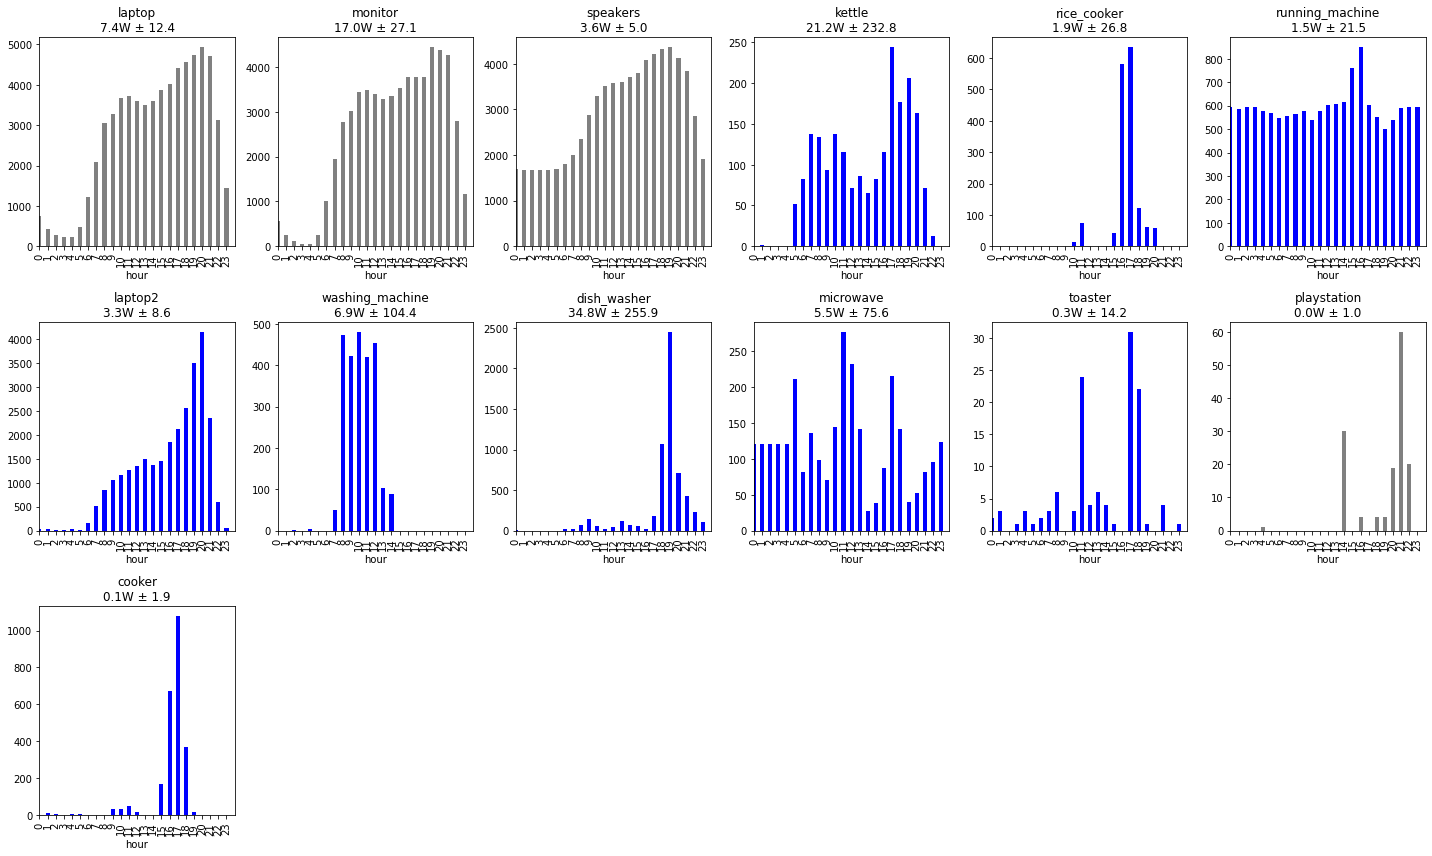

In [52]:
# we prepare our plot
fig = plt.figure(figsize=(20, 12));

# for each column
for k, col in enumerate(all_groups):
    # we add a subplot
    ax = fig.add_subplot(3, 6, k+1)

    pd.DataFrame(house2[house2[col] > 0].index.hour.value_counts(), index=range(24)).reset_index(drop=False).sort_values(by='index').plot.bar(x='index', y='datetime', color='blue' if col in active_labels else 'grey', legend=None, ax=ax);
    ax.set_xlim(0, 24)
    #pd.DataFrame(house1_activity_blk2[house1_activity_blk2[col] > 0].index.hour).reset_index(drop=False).sort_values(by='index').plot(kind='hist', width=0.7, x='index', y='datetime', color='blue' if col in labels_active else 'grey', bins=range(24), ax=ax);
    
    
    ax.set_xlabel('hour')
    ax.set_title(f'{col}\n{house2[col].mean():.1f}W ± {house2[col].std():.1f}')

plt.tight_layout()
plt.show();

In [65]:
house2[['mains', 'activity']].to_csv('data/ukdale/house2_power_labels.csv')